#### This file contains the sentiment analysis model that will classify events as ```success``` or ```failure```

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
import os

In [3]:
conf = pyspark.SparkConf()
conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.driver.memory','8g')
conf.set('spark.ui.showConsoleProgress', False)
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/03 14:24:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/03 14:24:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/opt/conda/envs/bigdata/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [12]:
sentiment140 = spark.read.csv('../data-processed/sentiment140_data.csv', header=True).select(['text', 'label'])

In [13]:
sentiment140.show()

+--------------------+-----+
|                text|label|
+--------------------+-----+
|@switchfoot http:...|    0|
|is upset that he ...|    0|
|@Kenichan I dived...|    0|
|my whole body fee...|    0|
|@nationwideclass ...|    0|
|@Kwesidei not the...|    0|
|         Need a hug |    0|
|@LOLTrish hey  lo...|    0|
|@Tatiana_K nope t...|    0|
|@twittera que me ...|    0|
|spring break in p...|    0|
|I just re-pierced...|    0|
|@caregiving I cou...|    0|
|@octolinz16 It it...|    0|
|@smarrison i woul...|    0|
|@iamjazzyfizzle I...|    0|
|Hollis' death sce...|    0|
|about to file taxes |    0|
|@LettyA ahh ive a...|    0|
|@FakerPattyPattz ...|    0|
+--------------------+-----+
only showing top 20 rows



In [2]:
sentiment140 = pd.read_csv('../data-processed/sentiment140_data.csv', index_col=0)

In [3]:
sentiment140.head()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [4]:
sentiment140.isna().sum()

text     0
label    0
dtype: int64

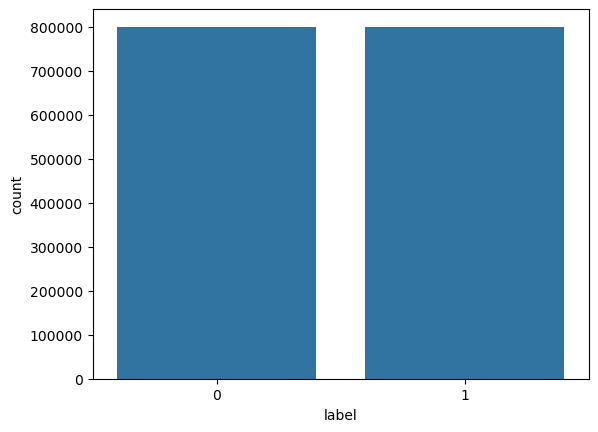

In [15]:
sns.countplot(data=sentiment140.toPandas(), x='label');

## Data Preparation

We will follow the following steps to prepare the data for our model
1. Lowercase the text
2. Remove stopwords from text
3. Remove punctuations from text since that is noise and meaningful information cannot be learned from them
4. Remove usernames, emojis, urls etc.
5. Replace contractions
6. Tokenize the text
7. Perform stemming and lemmatization on text

#### Lowercase the text

In [19]:
sentiment140 = sentiment140.withColumn('text', F.lower(F.col('text')))

In [20]:
sentiment140.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|@switchfoot http:...|    0|
|is upset that he ...|    0|
|@kenichan i dived...|    0|
|my whole body fee...|    0|
|@nationwideclass ...|    0|
|@kwesidei not the...|    0|
|         need a hug |    0|
|@loltrish hey  lo...|    0|
|@tatiana_k nope t...|    0|
|@twittera que me ...|    0|
+--------------------+-----+
only showing top 10 rows



#### Remove stopwords from text

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
from nltk.corpus import stopwords

In [26]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [44]:
def removeStopwords(text):
  return " ".join([word for word in text.split() if word not in stopwords.words('english')])

removeStopwordsUDF = F.udf(removeStopwords)

In [31]:
sentiment140 = sentiment140.withColumn('text', removeStopwordsUDF(F.col('text')))

In [32]:
sentiment140.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|@switchfoot http:...|    0|
|upset can't updat...|    0|
|@kenichan dived m...|    0|
|whole body feels ...|    0|
|@nationwideclass ...|    0|
|@kwesidei whole crew|    0|
|            need hug|    0|
|@loltrish hey lon...|    0|
|     @tatiana_k nope|    0|
|@twittera que mue...|    0|
+--------------------+-----+
only showing top 10 rows



#### Remove punctuations

In [33]:
import string

In [34]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [43]:
def remove_punctuations(text):
    # Make a translation table that maps all punctuation characters to None
    translator = str.maketrans("", "", string.punctuation)

    # Apply the translation table to the input string
    return text.translate(translator)

removePunctuationsUDF = F.udf(remove_punctuations)

In [41]:
sentiment140 = sentiment140.withColumn('text', removePunctuationsUDF(F.col('text')))

In [42]:
sentiment140.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|switchfoot httptw...|    0|
|upset cant update...|    0|
|kenichan dived ma...|    0|
|whole body feels ...|    0|
|nationwideclass n...|    0|
| kwesidei whole crew|    0|
|            need hug|    0|
|loltrish hey long...|    0|
|       tatianak nope|    0|
| twittera que muera |    0|
+--------------------+-----+
only showing top 10 rows



#### Remove emails, emojis, urls etc.

In [62]:
import emoji
import re

In [63]:
url_regex = '((www\.[^\s]+)|(https?://[^\s]+))'
username_regex = '@[^\s]+'

In [65]:
def remove_urls(text):
  return re.sub(url_regex, '', text)

def remove_usernames(text):
  return re.sub(username_regex, '', text)

def remove_emojis(text):
  return emoji.demojize(text)

remove_urlsUDF = F.udf(remove_urls)
remove_usernamesUDF = F.udf(remove_usernames)
remove_emojisUDF = F.udf(remove_emojis)

In [66]:
sentiment140 = sentiment140.withColumn('text', remove_urlsUDF(F.col('text')))
sentiment140 = sentiment140.withColumn('text', remove_usernamesUDF(F.col('text')))
sentiment140 = sentiment140.withColumn('text', remove_emojisUDF(F.col('text')))

In [68]:
sentiment140.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|switchfoot httptw...|    0|
|upset cant update...|    0|
|kenichan dived ma...|    0|
|whole body feels ...|    0|
|nationwideclass n...|    0|
| kwesidei whole crew|    0|
|            need hug|    0|
|loltrish hey long...|    0|
|       tatianak nope|    0|
| twittera que muera |    0|
+--------------------+-----+
only showing top 10 rows



#### Tokenizing the text

In [69]:
from nltk.tokenize import RegexpTokenizer

In [70]:
tokenizer = RegexpTokenizer('\w+')

In [73]:
def tokenize(text):
    return tokenizer.tokenize(text)

tokenizeUDF = F.udf(tokenize)

In [76]:
sentiment140 = sentiment140.withColumn('text', tokenizeUDF(F.col('text')))

In [77]:
sentiment140.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|[switchfoot, http...|    0|
|[upset, cant, upd...|    0|
|[kenichan, dived,...|    0|
|[whole, body, fee...|    0|
|[nationwideclass,...|    0|
|[kwesidei, whole,...|    0|
|         [need, hug]|    0|
|[loltrish, hey, l...|    0|
|    [tatianak, nope]|    0|
|[twittera, que, m...|    0|
+--------------------+-----+
only showing top 10 rows



### Stemming and Lemmatizing the text

In [78]:
from nltk.stem import PorterStemmer

In [79]:
stemmer = nltk.PorterStemmer()

In [80]:
from nltk.tokenize import word_tokenize

In [81]:
def stemming(text):
  return [stemmer.stem(word) for word in text]

stemmingUDF = F.udf(stemming)

In [83]:
sentiment140 = sentiment140.withColumn('text', stemmingUDF(F.col('text')))

In [84]:
sentiment140.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|[switchfoot, http...|    0|
|[upset, cant, upd...|    0|
|[kenichan, dive, ...|    0|
|[whole, bodi, fee...|    0|
|[nationwideclass,...|    0|
|[kwesidei, whole,...|    0|
|         [need, hug]|    0|
|[loltrish, hey, l...|    0|
|    [tatianak, nope]|    0|
|[twittera, que, m...|    0|
+--------------------+-----+
only showing top 10 rows



In [85]:
lemmatizer = nltk.WordNetLemmatizer()

In [86]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...


True

In [87]:
def lemmatize(text):
    return [lemmatizer.lemmatize(word) for word in text]

lemmatizeUDF = F.udf(lemmatize)

In [90]:
sentiment140 = sentiment140.withColumn('text', lemmatizeUDF(F.col('text')))

In [91]:
sentiment140.show(10)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|[switchfoot, http...|    0|
|[upset, cant, upd...|    0|
|[kenichan, dive, ...|    0|
|[whole, bodi, fee...|    0|
|[nationwideclass,...|    0|
|[kwesidei, whole,...|    0|
|         [need, hug]|    0|
|[loltrish, hey, l...|    0|
|    [tatianak, nope]|    0|
|[twittera, que, m...|    0|
+--------------------+-----+
only showing top 10 rows

